## Generate Image Embeddings with `ResNet50` Pretrained network

In [613]:
### IMPORT PACKAGES ###

import numpy as np

import os
from os.path import isfile, join
import re
import json
import cv2

import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

import tqdm

### Import Image data and create data structures

In [46]:
### READ FOLDER NAMES ###

root=r'C:\Users\ppriyadarsha\Google Drive\1. UoP Stuff\1. SuSe_2020\Reinforcement Learning for NLP\Project\codes\rl4nlp\data\unzip_data\annotations\saved_imgs'

dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
dirlist.sort()
dirlist

['phrase_1_go_through_opening',
 'phrase_2_move_down',
 'phrase_3_move_up',
 'phrase_4_move_to_left',
 'phrase_5_move_to_right',
 'phrase_6_turn_left',
 'phrase_7_turn_right']

In [48]:
### READ .IMG FILE NAMES IN EACH FOLDER ###

def get_text(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [get_text(c) for c in re.split(r'(\d+)', text) ]

img_li_dic = {}

for folder in dirlist:
    temp_root = root+"/"+folder
    img_li_dic[folder] = [f for f in os.listdir(temp_root) if isfile(join(temp_root, f))]
    img_li_dic[folder].sort(key=natural_keys)

    
### EXTRACT UNIQUE `_qX_` TAGS OF IMAGE NAME (WITHIN EACH FOLDER) ###

q_sets = {}
for dirr in dirlist:
    temp_li = ["_"+item[9:11]+"_" for item in img_li_dic[dirr]]
    q_sets[dirr] = list(set(temp_li))
    q_sets[dirr].sort()

    
### GET SEPARATE IMAGE NAMES BY `_qx_` TAGS WITHIN EACH FOLDER

img_li_dic = {}

for folder in dirlist:
    temp_root = root+"/"+folder
    img_li_dic[folder] = [f for f in os.listdir(temp_root) if isfile(join(temp_root, f))]
    img_li_dic[folder].sort(key=natural_keys)

    
### ARRANGE IMAGE NAMES (WITHIN EACH FOLDER) BY `_qX_` TAGS ### 

files_names_by_q = {}

for dirr in dirlist:
    
    name_by_q = {}    

    for q in q_sets[dirr]:
        name_by_q[q] = [name for name in img_li_dic[dirr] if q in name ]
    
    files_names_by_q[dirr] = name_by_q 

    
### IMPORT IMAGES - INTO THE SAME STRUCTURE USED IN `files_names_by_q` DICTIONARY ###

imgs_files_dic = {}

for dirr in dirlist:
    
    imgs_in_file_dic = {}
    
    for key, files in files_names_by_q[dirr].items():
        
        imgs_li = []
        
        for file in files:
            
            temp_path = root+"/"+dirr+"/"+file
            
            temp_img = cv2.imread(temp_path)
            temp_img = cv2.resize(temp_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
            imgs_li.append(temp_img)
        
        imgs_in_file_dic[key] = imgs_li
    
    imgs_files_dic[dirr] = imgs_in_file_dic

    
### ARRANGE IMAGE-FILE-NAMES : 3 CONSECUTIVE IMAGE-FILE NAMES PUT INTO A LIST (FOR EACH `_qX_` tag)
img_file_names_dic_arranged = {}

for phrase, folder_data in files_names_by_q .items():
    
    imgs_in_file_dic = {}
    
    for q_tag, image_list in folder_data.items():
        
        imgs_in_qtag = {}
        q_count = 0
        
        for first, second, third in zip(image_list, image_list[1:],image_list[2:]):
            
            imgs_in_qtag[str(q_count)] = [first, second, third]
            q_count += 1
        
        imgs_in_file_dic[q_tag] = imgs_in_qtag
    
    img_file_names_dic_arranged[phrase] = imgs_in_file_dic
    

### ARRANGE IMAGES : 3 CONSECUTIVE IMAGES PUT INTO A LIST (WITHIN EACH `_qX_` tag - PER EACH FOLDER)
img_files_dic_arranged = {}

for phrase, folder_data in imgs_files_dic.items():
    
    imgs_in_file_dic = {}
    
    for q_tag, image_list in folder_data.items():
        
        imgs_in_qtag = {}
        q_count = 0
        
        for first, second, third in zip(image_list, image_list[1:],image_list[2:]):
            
            imgs_in_qtag[str(q_count)] = [first, second, third]
            q_count += 1
        
        imgs_in_file_dic[q_tag] = imgs_in_qtag
    
    img_files_dic_arranged[phrase] = imgs_in_file_dic
    

SAMPLE FOLDER: phrase_4_move_to_left

Q-TAG: _q1_
Q-TAG LIST INDEX: 0


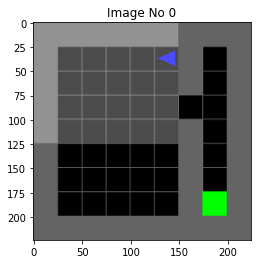

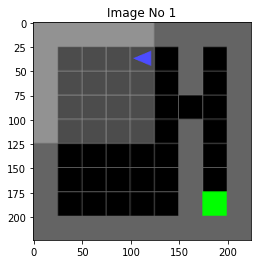

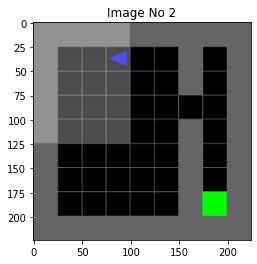

Q-TAG LIST INDEX: 1


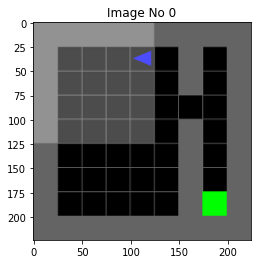

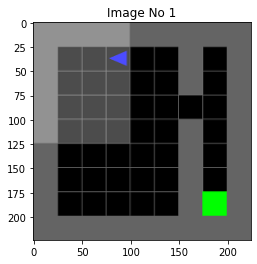

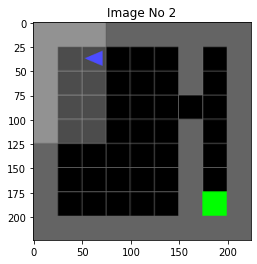

Q-TAG LIST INDEX: 2


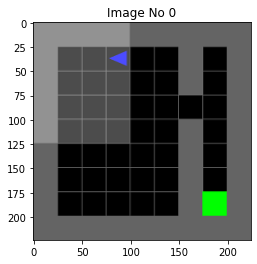

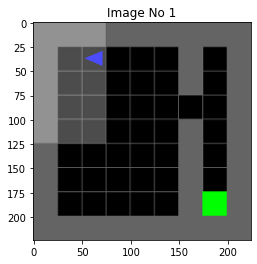

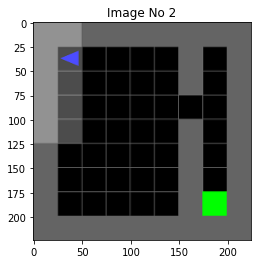

Q-TAG: _q2_
Q-TAG LIST INDEX: 0


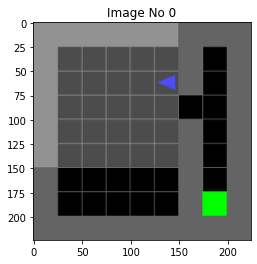

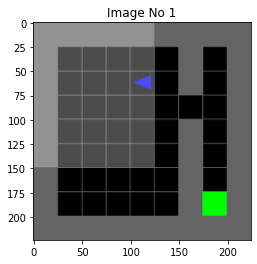

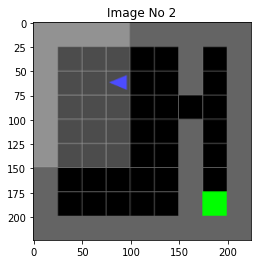

Q-TAG LIST INDEX: 1


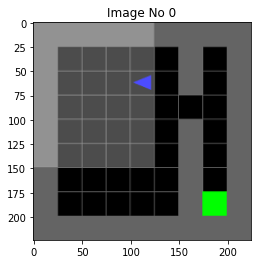

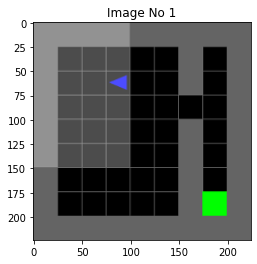

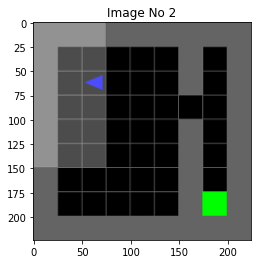

Q-TAG LIST INDEX: 2


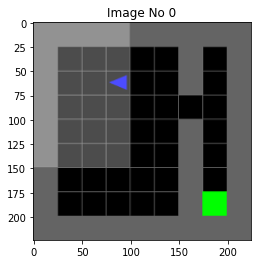

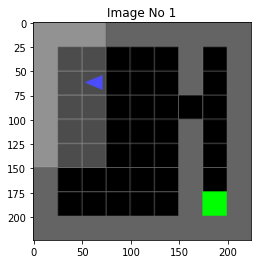

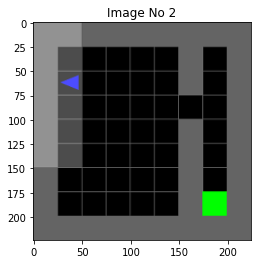

In [394]:
### SAMPLE 15 CONSECUTIVE IMAGES IN A LIST FROM ANY SELECTED FOLDER -- FOR VALIDATION PURPOSES ###

sample_folder_name = dirlist[3]

sample_img_count = 0

for phrase, folder_data in img_files_dic_arranged.items():
    
    if phrase != sample_folder_name:
        continue
        
    print("SAMPLE FOLDER: "+ phrase +'\n')
    
    for q_tag, image_list_data in folder_data.items():
                    
        print("Q-TAG: "+ q_tag)
        
        done = False        
        
        for img_li_idx, img_li in image_list_data.items():
            
            print("Q-TAG LIST INDEX: "+ img_li_idx)
            
            img_no = 0
            for img in img_li:
                plt.title('Image No '+ str(img_no))
                plt.imshow(img)
                plt.show()
                img_no += 1
                
                sample_img_count += 1
    
            if sample_img_count>15:
                done = True
                break
        
        if done:
            break

In [ ]:
### GENERATE IMAGE EMBEDDINGS FOR IMAGE LISTS (OF LENGTH 3) ###

img_model = models.resnet50(pretrained=True)
layer = img_model._modules.get('avgpool')

img_model.eval() # Set to evaluation mode

def get_embeddings(image_array):

    temp_imgs_l = []
    
    for image in image_array:
        temp_img = Image.fromarray(image).convert('RGB')
        temp_img = normalize(to_tensor(scaler(temp_img)))
        temp_imgs_l.append(temp_img)
        
    temp_imgs_l = torch.cat(temp_imgs_l)
    temp_imgs_l = temp_imgs_l.reshape((3,3,224,224))
                           
    # create PyTorch Var. w/ pre-processed image
    t_img = Variable(temp_imgs_l)
    
    # create an empty vector to hold the embeddings vector
    my_embedding = torch.zeros(2048*3)
    
    # function to copy the output of the layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(2048*3))
 
    # attach that function to the `avgpool` layer
    h = layer.register_forward_hook(copy_data)
    
    # run the model on the image
    img_model(t_img)
    
    # remove the copy function from the layer
    h.remove()
    
    # return the feature vector
    return my_embedding


### GENERATE IMAGE EMBEDDINGS ###

embeddings_by_phase_dic = {}

for phrase, folder_data in tqdm.notebook.tqdm(img_files_dic_arranged.items()):
    
    embeddings_li = []
    
    for q_tag, image_list_data in folder_data.items():      
        
        for img_li_idx, img_li in image_list_data.items():
            
            embeddings_li.append(get_embeddings(img_li).numpy().tolist())
        
    embeddings_by_phase_dic[phrase] = embeddings_li

    
### STORE IMAGE EMBEDDINGS ###

with open('image_embeddings_w_phrases.json', 'w') as fp:
    json.dump(embeddings_by_phase_dic, fp)